#### Предупреждение:
Запуск *только* из [GoogleCollab](https://colab.research.google.com/)

## Подготовка

### Установка библиотек

In [1]:
!pip install tensorflow numpy
!pip uninstall -y opencv-python
!pip install -q tf-models-nightly

     |████████████████████████████████| 462 kB 5.1 MB/s 
Found existing installation: opencv-python 4.1.2.30
Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 2.2 MB 5.0 MB/s 
     |████████████████████████████████| 503.2 MB 4.9 kB/s 
     |████████████████████████████████| 90 kB 9.9 MB/s 
     |████████████████████████████████| 38.2 MB 1.3 MB/s 
     |████████████████████████████████| 1.1 MB 47.8 MB/s 
     |████████████████████████████████| 99 kB 9.9 MB/s 
     |████████████████████████████████| 237 kB 66.7 MB/s 
     |████████████████████████████████| 352 kB 70.3 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 636 kB 54.6 MB/s 
     |████████████████████████████████| 4.6 MB 52.7 MB/s 
     |████████████████████████████████| 1.2 MB 41.9 MB/s 
     |████████████████████████████████| 1.7 MB 71.7 MB/s 
     |████████████████████████████████| 438 kB 59.4 MB/s

### Импорт библиотек

In [2]:
import pprint
import tempfile

from IPython import display
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

import tensorflow_models as tfm

# Not in the tfm public API for v2.9. Will be available as `vision.serving` in v2.10
from official.vision.serving import export_saved_model_lib

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:43: UserWarning: You are currently using a nightly version of TensorFlow (2.10.0-dev20220427). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  UserWarning,


## Настройки

### Модель `ResNet-18` для набора данных `Cifar-10`

In [ ]:
exp_config = tfm.core.exp_factory.get_exp_config('resnet_imagenet')
tfds_name = 'cifar10'
ds_info = tfds.builder(tfds_name ).info
ds_info

In [4]:
exp_config.task.model.num_classes = 10
exp_config.task.model.input_size = list(ds_info.features["image"].shape)
exp_config.task.model.backbone.resnet.model_id = 18

### Тренировочный и тестовый набор

In [5]:
batch_size = 128

exp_config.task.train_data.input_path = ''
exp_config.task.train_data.tfds_name = tfds_name
exp_config.task.train_data.tfds_split = 'train'
exp_config.task.train_data.global_batch_size = batch_size

exp_config.task.validation_data.input_path = ''
exp_config.task.validation_data.tfds_name = tfds_name
exp_config.task.validation_data.tfds_split = 'test'
exp_config.task.validation_data.global_batch_size = batch_size

### Учитель модели

In [6]:
logical_device_names = [logical_device.name for logical_device in tf.config.list_logical_devices()]

if 'GPU' in ''.join(logical_device_names):
  print('This may be broken in Colab.')
  device = 'GPU'
elif 'TPU' in ''.join(logical_device_names):
  print('This may be broken in Colab.')
  device = 'TPU'
else:
  print('Running on CPU is slow, so only train it for a few steps.')
  device = 'CPU'

if device=='CPU':
  train_steps = 20
  exp_config.trainer.steps_per_loop = 5
else:
  train_steps=5000
  exp_config.trainer.steps_per_loop = 100

exp_config.trainer.summary_interval = 100
exp_config.trainer.checkpoint_interval = train_steps
exp_config.trainer.validation_interval = 1000
exp_config.trainer.validation_steps =  ds_info.splits['test'].num_examples // batch_size
exp_config.trainer.train_steps = train_steps
exp_config.trainer.optimizer_config.learning_rate.type = 'cosine'
exp_config.trainer.optimizer_config.learning_rate.cosine.decay_steps = train_steps
exp_config.trainer.optimizer_config.learning_rate.cosine.initial_learning_rate = 0.1
exp_config.trainer.optimizer_config.warmup.linear.warmup_steps = 100

Running on CPU is slow, so only train it for a few steps.


### Просмотр получившейся конфигурации модели

In [7]:
pprint.pprint(exp_config.as_dict())

display.Javascript("google.colab.output.setIframeHeight('300px');")

{'runtime': {'all_reduce_alg': None,
             'batchnorm_spatial_persistent': False,
             'dataset_num_private_threads': None,
             'default_shard_dim': -1,
             'distribution_strategy': 'mirrored',
             'enable_xla': True,
             'gpu_thread_mode': None,
             'loss_scale': None,
             'mixed_precision_dtype': None,
             'num_cores_per_replica': 1,
             'num_gpus': 0,
             'num_packs': 1,
             'per_gpu_thread_count': 0,
             'run_eagerly': False,
             'task_index': -1,
             'tpu': None,
             'tpu_enable_xla_dynamic_padder': None,
             'worker_hosts': None},
 'task': {'differential_privacy_config': None,
          'evaluation': {'top_k': 5},
          'init_checkpoint': None,
          'init_checkpoint_modules': 'all',
          'losses': {'l2_weight_decay': 0.0001,
                     'label_smoothing': 0.0,
                     'loss_weight': 1.0,
         

<IPython.core.display.Javascript object>

### Стратегия распространения

In [8]:
logical_device_names = [logical_device.name for logical_device in tf.config.list_logical_devices()]

if exp_config.runtime.mixed_precision_dtype == tf.float16:
    tf.keras.mixed_precision.set_global_policy('mixed_float16')

if 'GPU' in ''.join(logical_device_names):
  distribution_strategy = tf.distribute.MirroredStrategy()
elif 'TPU' in ''.join(logical_device_names):
  tf.tpu.experimental.initialize_tpu_system()
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='/device:TPU_SYSTEM:0')
  distribution_strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
  print('Warning: this will be really slow.')
  distribution_strategy = tf.distribute.OneDeviceStrategy(logical_device_names[0])


## Необходимые действия

### Создание Task-объекта (`tfm.core.base_task.Task`) из `config_definitions.TaskConfig`.

*Task-Объект имеет все методы, необходимые для построения набора данных, построения модели и запуска обучения и оценки. Эти методы управляются `tfm.core.train_lib.run_experiment`.*

In [10]:
with distribution_strategy.scope():
  model_dir = tempfile.mkdtemp()
  task = tfm.core.task_factory.get_task(exp_config.task, logging_dir=model_dir)

### Текущий вид модели

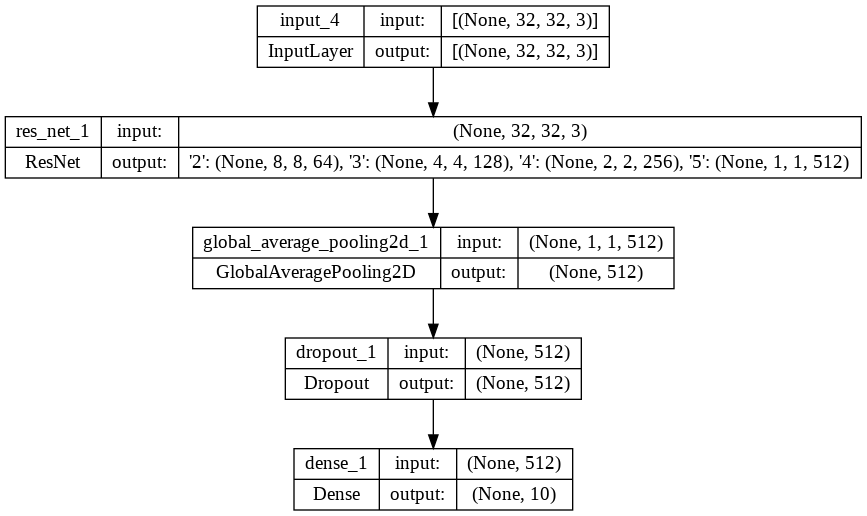

In [11]:
tf.keras.utils.plot_model(task.build_model(), show_shapes=True)

### Подготовка набора данных `cifar10`

In [12]:
for images, labels in task.build_inputs(exp_config.task.train_data).take(1):
  print()
  print(f'images.shape: {str(images.shape):16}  images.dtype: {images.dtype!r}')
  print(f'labels.shape: {str(labels.shape):16}  labels.dtype: {labels.dtype!r}')


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteBU754W/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteBU754W/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.

images.shape: (128, 32, 32, 3)  images.dtype: tf.float32
labels.shape: (128,)            labels.dtype: tf.int32


## Визуализация

### Обучающие данные

*Загрузчик данных применяет нормализацию z-score `preprocess_ops.normalize_image(image, offset=MEAN_RGB, scale=STDDEV_RGB)`, поэтому изображения, возвращаемые набором данных, не могут быть непосредственно отображены стандартными инструментами. Код визуализации должен масштабировать данные в диапазон [0,1].*

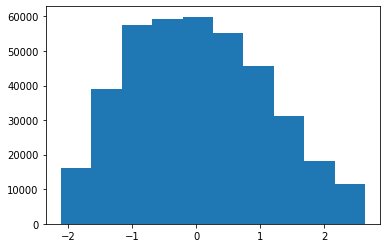

In [13]:
plt.hist(images.numpy().flatten());

#### Использование `ds_info`(который является экземпляром `tfds.core.DatasetInfo`) для поиска текстовых описаний каждого идентификатора класса.

In [16]:
label_info = ds_info.features['label']
label_info.int2str(1)

'automobile'

#### Использование функции функции

In [17]:
def show_batch(images, labels, predictions=None):
  plt.figure(figsize=(10, 10))
  min = images.numpy().min()
  max = images.numpy().max()
  delta = max - min

  for i in range(12):
    plt.subplot(6, 6, i + 1)
    plt.imshow((images[i]-min) / delta)
    if predictions is None:
      plt.title(label_info.int2str(labels[i]))
    else:
      if labels[i] == predictions[i]:
        color = 'g'
      else:
        color = 'r'
      plt.title(label_info.int2str(predictions[i]), color=color)
    plt.axis("off")

<Figure size 720x720 with 0 Axes>

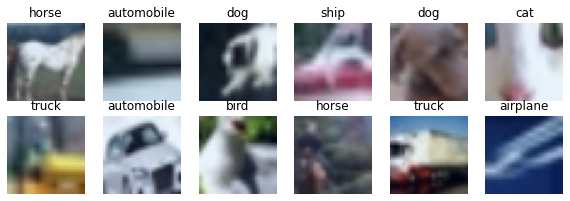

In [18]:
plt.figure(figsize=(10, 10))
for images, labels in task.build_inputs(exp_config.task.train_data).take(1):
  show_batch(images, labels)

### Тренировочные данные

#### Пакет изображений из набора данных проверки

<Figure size 720x720 with 0 Axes>

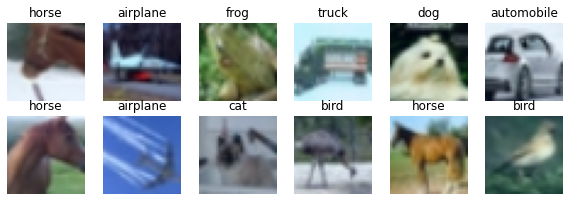

In [19]:
plt.figure(figsize=(10, 10));
for images, labels in task.build_inputs(exp_config.task.validation_data).take(1):
  show_batch(images, labels)


## Обучение и оценка

### Тренировка

In [20]:
model, eval_logs = tfm.core.train_lib.run_experiment(
    distribution_strategy=distribution_strategy,
    task=task,
    mode='train_and_eval',
    params=exp_config,
    model_dir=model_dir,
    run_post_eval=True)

restoring or initializing model...
initialized model.
train | step:      0 | training until step 20...
train | step:      5 | steps/sec:    0.2 | output: 
    {'accuracy': 0.09375,
     'learning_rate': 0.0,
     'top_5_accuracy': 0.471875,
     'training_loss': 2.91297}
saved checkpoint to /tmp/tmp6_w6ttng/ckpt-5.
train | step:     10 | steps/sec:    0.2 | output: 
    {'accuracy': 0.1,
     'learning_rate': 0.0,
     'top_5_accuracy': 0.48125,
     'training_loss': 2.9269266}
train | step:     15 | steps/sec:    0.2 | output: 
    {'accuracy': 0.1171875,
     'learning_rate': 0.0,
     'top_5_accuracy': 0.5046875,
     'training_loss': 2.8682055}
train | step:     20 | steps/sec:    0.2 | output: 
    {'accuracy': 0.0953125,
     'learning_rate': 0.0,
     'top_5_accuracy': 0.5234375,
     'training_loss': 2.8632832}
 eval | step:     20 | running 78 steps of evaluation...
 eval | step:     20 | eval time:   21.7 sec | output: 
    {'accuracy': 0.10086138,
     'top_5_accuracy': 0.48

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


### Вид модели

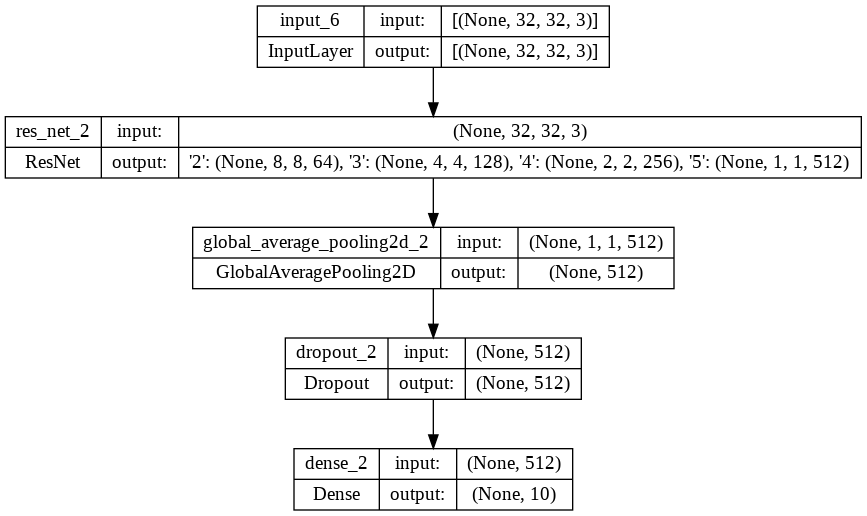

In [21]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Метрики

In [22]:
for key, value in eval_logs.items():
    print(f'{key:20}: {value.numpy():.3f}')

accuracy            : 0.101
top_5_accuracy      : 0.483
validation_loss     : 2.628


### Наглядное определение изображений

4/4 [==============================] - 0s 69ms/step


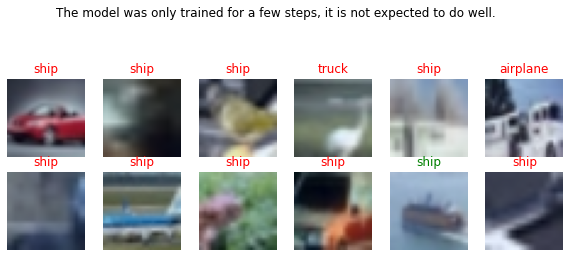

In [25]:
for images, labels in task.build_inputs(exp_config.task.train_data).take(1):
  predictions = model.predict(images)
  predictions = tf.argmax(predictions, axis=-1)

show_batch(images, labels, tf.cast(predictions, tf.int32))

if device=='CPU':
  plt.suptitle('The model was only trained for a few steps, it is not expected to do well.')

## Экспорт сохранённой модели

In [26]:
export_saved_model_lib.export_inference_graph(
    input_type='image_tensor',
    batch_size=1,
    input_image_size=[32, 32],
    params=exp_config,
    checkpoint_path=tf.train.latest_checkpoint(model_dir),
    export_dir='./export/')

INFO:tensorflow:Assets written to: ./export/assets


INFO:tensorflow:Assets written to: ./export/assets


## Импорт сохранённой модели

In [27]:
imported = tf.saved_model.load('./export/')
model_fn = imported.signatures['serving_default']

### Визуализация предсказаний

<Figure size 720x720 with 0 Axes>

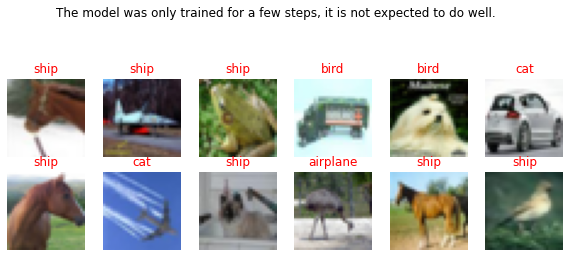

In [28]:
plt.figure(figsize=(10, 10))
for data in tfds.load('cifar10', split='test').batch(12).take(1):
  predictions = []
  for image in data['image']:
    index = tf.argmax(model_fn(image[tf.newaxis, ...])['logits'], axis=1)[0]
    predictions.append(index)
  show_batch(data['image'], data['label'], predictions)

  if device=='CPU':
    plt.suptitle('The model was only trained for a few steps, it is not expected to do well.')

## Вывод

Как видно, модель более серьёзная и требует серьёзного обучения, а не копирования по инструкции. Как следствие, низкая точность модели. Это последний эксперимент.